# TB Drug Susceptibility Mutations

In [1]:
# Import Statements
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from imblearn.metrics import specificity_score 
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path
cwd = Path.cwd()

## Data Preprocessing
Since we are using stratified kfold, a validation split is not necesssary.

### Load data

In [2]:
df = pd.read_csv('filtered.csv')

X = df[['original', 'new']]
X.columns = ['WT', 'Mutant']
pos = df['position']
dna = df['dna_binding']
dimer = df['dimerisation']
ligand = df['ligand_binding']
y = df['drug']

In [3]:
aa_prop = X.replace({'Gly': 'non-polar', 'Ala': 'non-polar', 'Val': 'non-polar', 'Cys': 'non-polar', 'Pro': 'non-polar', 
                      'Leu': 'non-polar', 'Ile': 'non-polar', 'Met': 'non-polar', 'Trp': 'non-polar', 'Phe': 'non-polar', 
                      'Ser': 'polar', 'Thr': 'polar', 'Tyr': 'polar', 'Asn': 'polar', 'Gln': 'polar', 
                      'Lys': 'pos', 'Arg': 'pos', 'His': 'polar', 'Asp': 'neg', 'Glu': 'neg'})
aa_prop.columns = ['WT Property', 'Mutant Property']

Note: Histidine is effectively neutral at pH 7.0. See https://doi.org/10.1073/pnas.212643999

In [4]:
# Hydrophobic = 1, Hydrophilic = -1
hydrophobic = X.replace({'Cys': 1, 'Ile': 1, 'Val': 1, 'Leu': 1, 'Phe': 1,
                         'Met': 1, 'Gly': 1, 'Ala': 1, 'Trp': 1, 'Tyr': 1,
                         'His': -1, 'Ser': -1, 'Thr': -1, 'Pro': -1, 'Asp': -1,
                         'Asn': -1, 'Gln': -1, 'Glu': -1, 'Arg': -1, 'Lys': -1})

hydrophobic.columns = ['WT Hydrophobicity', 'Mutant Hydrophobicity']

Hydrophobicity scale based on JANIN, J. Surface and inside volumes in globular proteins. Nature 277, 491–492 (1979). https://doi.org/10.1038/277491a0

Top 10 most hydrophobic are coded as 1, else -1

In [5]:
def get_hydrophobic(x):
    if x[0] == -1 and x[1] == 1:
        return 1
    if x[0] == 1 and x[1] == -1:
        return -1
    else:
        return 0
    
hydrophobic_change = hydrophobic.apply(get_hydrophobic, axis=1)
hydrophobic_change.name = 'Hydrophobicity Change'

In [6]:
def get_charge(x):
    if x[0] == 'pos' and (x[1] == 'non-polar' or x[1] == 'polar'):
        return -1
    elif x[0] == 'pos' and x[1] == 'neg':
        return -2
    elif x[0] == 'neg' and (x[1] == 'non-polar' or x[1] == 'polar'):
        return 1
    elif x[0] == 'neg' and x[1] == 'pos':
        return 2
    elif (x[0] == 'non-polar' or x[0] == 'polar') and x[1] == 'pos':
        return 1
    elif (x[0] == 'non-polar' or x[0] == 'polar') and x[1] == 'neg':
        return -1
    
    else:
        return 0
    
charge = aa_prop.apply(get_charge, axis=1)
charge.name = 'Charge Change'

In [7]:
mw = X.replace({'Gly': 75, 'Ala': 89, 'Val': 117, 'Cys': 121, 'Pro': 115, 
                      'Leu': 131, 'Ile': 131, 'Met': 149, 'Trp': 204, 'Phe': 165, 
                      'Ser': 105, 'Thr': 119, 'Tyr': 181, 'Asn': 132, 'Gln': 146, 
                      'Lys': 146, 'Arg': 174, 'His': 155, 'Asp': 133, 'Glu': 147})
mw.columns = ['WT MW', 'Mutant MW']

mw_change = mw['Mutant MW'] - mw['WT MW']
mw_change.name = 'MW Change'

### Combine Features

In [8]:
X = pd.concat([X, 
               aa_prop, 
               hydrophobic, 
               hydrophobic_change, 
               charge, 
               mw, 
               mw_change,
               dna,
               dimer,
               ligand,
               pos], axis=1)
display(X)

,WT,Mutant,WT Property,Mutant Property,WT Hydrophobicity,Mutant Hydrophobicity,Hydrophobicity Change,Charge Change,WT MW,Mutant MW,MW Change,dna_binding,dimerisation,ligand_binding,position
0,Val,Ala,non-polar,non-polar,1,1,0,0,117,89,-28,0,0,0,1
1,Ser,Arg,polar,pos,-1,-1,0,1,105,174,69,0,0,0,2
2,Ser,Ile,polar,non-polar,-1,1,1,0,105,131,26,0,0,0,2
3,Asp,Gly,neg,non-polar,-1,1,1,1,133,75,-58,0,0,0,5
4,Met,Leu,non-polar,non-polar,1,1,0,0,149,131,-18,0,1,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,Met,Thr,non-polar,polar,1,-1,-1,0,149,119,-30,0,1,0,146
87,Leu,Pro,non-polar,non-polar,1,-1,-1,0,131,115,-16,0,1,0,154
88,Tyr,Asp,polar,neg,1,-1,-1,-1,181,133,-48,0,1,0,157
89,Tyr,His,polar,polar,1,-1,-1,0,181,155,-26,0,1,0,157


In [9]:
# to_save = pd.concat([y, X], axis=1)
# to_save.to_csv(cwd / 'parsed_data.csv', sep=',', index=False, header=True)

### Encoding

In [10]:
from sklearn.preprocessing import OrdinalEncoder

aa_encoder = OrdinalEncoder()
prop_encoder = OrdinalEncoder()

X[['WT', 'Mutant']] = aa_encoder.fit_transform(X[['WT', 'Mutant']]) + 1
X[['WT Property', 'Mutant Property']] = prop_encoder.fit_transform(X[['WT Property', 'Mutant Property']]) + 1


y = y.replace({'Resistant': 1, 'Susceptible': 0})

In [11]:
display(X)

,WT,Mutant,WT Property,Mutant Property,WT Hydrophobicity,Mutant Hydrophobicity,Hydrophobicity Change,Charge Change,WT MW,Mutant MW,MW Change,dna_binding,dimerisation,ligand_binding,position
0,17.0,1.0,2.0,2.0,1,1,0,0,117,89,-28,0,0,0,1
1,13.0,2.0,3.0,4.0,-1,-1,0,1,105,174,69,0,0,0,2
2,13.0,10.0,3.0,2.0,-1,1,1,0,105,131,26,0,0,0,2
3,4.0,8.0,1.0,2.0,-1,1,1,1,133,75,-58,0,0,0,5
4,11.0,11.0,2.0,2.0,1,1,0,0,149,131,-18,0,1,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,11.0,17.0,2.0,3.0,1,-1,-1,0,149,119,-30,0,1,0,146
87,10.0,15.0,2.0,2.0,1,-1,-1,0,131,115,-16,0,1,0,154
88,16.0,4.0,3.0,1.0,1,-1,-1,-1,181,133,-48,0,1,0,157
89,16.0,9.0,3.0,3.0,1,-1,-1,0,181,155,-26,0,1,0,157


In [12]:
to_save = pd.concat([y, X], axis=1)
to_save.to_csv(cwd / 'encoded_mutations.csv', sep=',', index=False, header=True)

### Train Test Split

Here I print the number of examples for each split of data.

In [13]:
n_splits = 10

pos = len(y[y == 1])
neg = len(y[y == 0])
split_sizes = pd.DataFrame({'Resistant': [pos - int(pos / n_splits), int(pos / n_splits)], 
                           'Susceptible': [neg - int(neg / n_splits), int(neg / n_splits)]}, index=['Train fold', 'Test fold'])

display(split_sizes)

# Get negative to positive ratio
ratio = sum(y == 0) / sum(y == 1)

,Resistant,Susceptible
Train fold,54,28
Test fold,6,3


## Optimising model hyperparameters
We use gridsearch to do hyperparameter optimisation (n_estimators, max_depth).
n_estimators: Number of tree stumps
max_depth: max depth of nodes in tree stumps

In [14]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, average_precision_score

In [15]:
def optimise_evaluate(X, y):
    np.random.seed(66)
    ratio = sum(y == 0) / sum(y == 1)
    
    # Hyperparemeter Optimisation using grid search (F1)
    model = XGBClassifier()
    n_estimators = range(50, 300, 10)
    max_depth = range(1, 5, 1)
    gamma = np.linspace(0.1, 3, 10)
    subsample = [0.6, 0.7, 0.8, 0.9, 1.0]
    colsample_bytree = np.linspace(0.1, 1, 20)
    
    param_grid = dict(max_depth=max_depth, 
                      n_estimators=n_estimators, 
                      colsample_bytree=colsample_bytree,
                      gamma=gamma,
                      subsample=subsample,
                      scale_pos_weight=[ratio])
    
    inner_cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
    outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

    # Inner CV
    model = RandomizedSearchCV(model, 
                               param_grid, 
                               scoring='f1',
                               n_iter=1000,
                               n_jobs=10, 
                               cv=inner_cv, 
                               verbose=0)

    model.fit(X, y)
    best_params = model.best_params_
    print(best_params)

    # Custom metrics
    precision = make_scorer(precision_score, average='binary')
    recall = make_scorer(recall_score, average='binary')
    specificity = make_scorer(specificity_score, average='binary')
    f1 = make_scorer(f1_score, average='binary')
    auprc = make_scorer(average_precision_score, average=None)
    
    scoring = {'precision': precision, 
               'recall': recall,
               'specificity': specificity,
               'AUPRC': auprc,
               'F1': f1}

    # Outer CV
    outer_results = cross_validate(model, X=X, y=y, cv=outer_cv, scoring=scoring)
    outer_results = pd.DataFrame(outer_results).mean()[['test_precision', 'test_recall', 'test_specificity',
                                                        'test_F1', 'test_AUPRC']]

    return outer_results, best_params

In [16]:
results, params = optimise_evaluate(X, y)


{'subsample': 0.7, 'scale_pos_weight': 0.5166666666666667, 'n_estimators': 160, 'max_depth': 3, 'gamma': 0.1, 'colsample_bytree': 0.38421052631578945}


In [17]:
display(results)

test_precision      0.836190
test_recall         0.783333
test_specificity    0.691667
test_F1             0.801076
test_AUPRC          0.804643
dtype: float64

## Fit optimised models

In [18]:
# Fit optimised model on all training data
drug_model = XGBClassifier(**params)
drug_model.fit(X=X, y=y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.38421052631578945,
              gamma=0.1, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=160, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=0.5166666666666667, subsample=0.7,
              tree_method=None, validate_parameters=False, verbosity=None)

## Interpreting model using SHAP values

### Feature importance
This is a plot of mean absolute SHAP values per feature

In [19]:
import shap
import matplotlib.pyplot as plt
explainer = shap.TreeExplainer(drug_model, feature_pertubation='interventional', model_output='probability', data=X)
shap_drug = explainer.shap_values(X)

### Plot of SHAP values per Feature

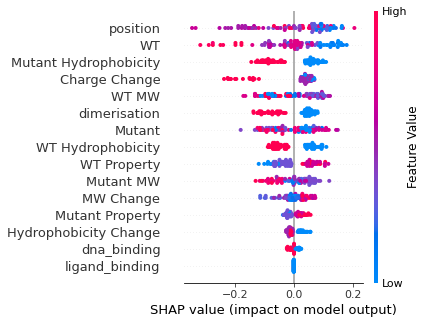

In [20]:
shap.summary_plot(shap_drug, X, show=False, plot_size=(4, 5), color_bar_label='Feature Value')
# fig, ax = plt.gcf(), plt.gca()
# ax.set_xlabel('SHAP Value')
plt.savefig(cwd / 'shap_summary_plot_120121.png', dpi=300, format='png', bbox_inches='tight')

In [21]:
shap_df = pd.DataFrame({'feature': X.columns, 'mean(|SHAP|)': np.absolute(shap_drug).mean(axis=0) * 100})
shap_df = shap_df.sort_values(by='mean(|SHAP|)', ascending=False).round(2)
display(shap_df)
shap_df.to_csv(cwd / 'mean_abs_shap.csv', index=False)

,feature,mean(|SHAP|)
14,position,10.11
0,WT,8.56
5,Mutant Hydrophobicity,7.39
7,Charge Change,7.07
8,WT MW,7.07
12,dimerisation,6.45
1,Mutant,6.41
4,WT Hydrophobicity,5.91
2,WT Property,5.38
9,Mutant MW,4.61


## Predictions

In [22]:
to_predict = pd.read_csv(cwd / 'to_predict_new.csv')
display(to_predict)

pos = to_predict['position']
dna = to_predict['dna_binding']
dimer = to_predict['dimerisation']
ligand = to_predict['ligand_binding']


encoded = to_predict[['original', 'new']]
encoded.columns = ['WT', 'Mutant']

aa_prop = encoded.replace({'Gly': 'non-polar', 'Ala': 'non-polar', 'Val': 'non-polar', 'Cys': 'non-polar', 'Pro': 'non-polar', 
                              'Leu': 'non-polar', 'Ile': 'non-polar', 'Met': 'non-polar', 'Trp': 'non-polar', 'Phe': 'non-polar', 
                              'Ser': 'polar', 'Thr': 'polar', 'Tyr': 'polar', 'Asn': 'polar', 'Gln': 'polar', 
                              'Lys': 'pos', 'Arg': 'pos', 'His': 'polar', 'Asp': 'neg', 'Glu': 'neg'})

aa_prop.columns = ['WT Property', 'Mutant Property']

hydrophobic = encoded.replace({'Cys': 1, 'Ile': 1, 'Val': 1, 'Leu': 1, 'Phe': 1,
                         'Met': 1, 'Gly': 1, 'Ala': 1, 'Trp': 1, 'Tyr': 1,
                         'His': -1, 'Ser': -1, 'Thr': -1, 'Pro': -1, 'Asp': -1,
                         'Asn': -1, 'Gln': -1, 'Glu': -1, 'Arg': -1, 'Lys': -1})

hydrophobic.columns = ['WT Hydrophobicity', 'Mutant Hydrophobicity']    
hydrophobic_change = hydrophobic.apply(get_hydrophobic, axis=1)
hydrophobic_change.name = 'Hydrophobicity Change'
    
charge = aa_prop.apply(get_charge, axis=1)
charge.name = 'Charge Change'

mw = encoded.replace({'Gly': 75, 'Ala': 89, 'Val': 117, 'Cys': 121, 'Pro': 115, 
                          'Leu': 131, 'Ile': 131, 'Met': 149, 'Trp': 204, 'Phe': 165, 
                          'Ser': 105, 'Thr': 119, 'Tyr': 181, 'Asn': 132, 'Gln': 146, 
                          'Lys': 146, 'Arg': 174, 'His': 155, 'Asp': 133, 'Glu': 147})
mw.columns = ['WT MW', 'Mutant MW']

mw_change = mw['Mutant MW'] - mw['WT MW']
mw_change.name = 'MW Change'

encoded = pd.concat([encoded, 
                     aa_prop, 
                     hydrophobic, 
                     hydrophobic_change, 
                     charge,
                     mw, 
                     mw_change,
                     dna,
                     dimer,
                     ligand,
                     pos], axis=1)


encoded[['WT', 'Mutant']] = aa_encoder.fit_transform(encoded[['WT', 'Mutant']]) + 1
encoded[['WT Property', 'Mutant Property']] = prop_encoder.fit_transform(encoded[['WT Property', 'Mutant Property']]) + 1

display(encoded)

,original,new,drug,effect score,effect,position,dna_binding,dimerisation,ligand_binding
0,Asn,Thr,Unknown,-0.455,Neutral,4,0,0,0
1,Gly,Val,Unknown,-0.257,Neutral,6,0,0,0
2,Val,Gly,Unknown,-0.833,Neutral,7,0,0,0
3,Val,Gly,Unknown,-0.833,Neutral,7,0,0,0
4,Asp,Glu,Unknown,-0.314,Neutral,8,0,0,0
...,...,...,...,...,...,...,...,...,...
138,Thr,Ile,Unknown,-1.712,Neutral,161,0,1,0
139,Thr,Pro,Unknown,-0.832,Neutral,161,0,1,0
140,Thr,Ile,Unknown,-1.712,Neutral,161,0,1,0
141,Thr,Pro,Unknown,-0.832,Neutral,161,0,1,0


,WT,Mutant,WT Property,Mutant Property,WT Hydrophobicity,Mutant Hydrophobicity,Hydrophobicity Change,Charge Change,WT MW,Mutant MW,MW Change,dna_binding,dimerisation,ligand_binding,position
0,3.0,17.0,3.0,3.0,-1,-1,0,0,132,119,-13,0,0,0,4
1,7.0,20.0,2.0,2.0,1,1,0,0,75,117,42,0,0,0,6
2,16.0,8.0,2.0,2.0,1,1,0,0,117,75,-42,0,0,0,7
3,16.0,8.0,2.0,2.0,1,1,0,0,117,75,-42,0,0,0,7
4,4.0,7.0,1.0,1.0,-1,-1,0,0,133,147,14,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,14.0,10.0,3.0,2.0,-1,1,1,0,119,131,12,0,1,0,161
139,14.0,15.0,3.0,2.0,-1,-1,0,0,119,115,-4,0,1,0,161
140,14.0,10.0,3.0,2.0,-1,1,1,0,119,131,12,0,1,0,161
141,14.0,15.0,3.0,2.0,-1,-1,0,0,119,115,-4,0,1,0,161


In [23]:
predicted = drug_model.predict_proba(encoded)[: ,1]

In [24]:
to_predict.insert(loc=to_predict.shape[1], column='predicted_probability_of_resistance', value=predicted)
display(to_predict)
to_predict = to_predict.rename({'original': 'WT', 'new': 'Variant', 
                                'drug': 'Drug Resistance', 'effect score': 'PROVEAN score'}, axis=1)
to_predict.to_csv(cwd / 'mutations_with_scores.120121.csv', index=False)

,original,new,drug,effect score,effect,position,dna_binding,dimerisation,ligand_binding,predicted_probability_of_resistance
0,Asn,Thr,Unknown,-0.455,Neutral,4,0,0,0,0.999218
1,Gly,Val,Unknown,-0.257,Neutral,6,0,0,0,0.734124
2,Val,Gly,Unknown,-0.833,Neutral,7,0,0,0,0.322569
3,Val,Gly,Unknown,-0.833,Neutral,7,0,0,0,0.322569
4,Asp,Glu,Unknown,-0.314,Neutral,8,0,0,0,0.983065
...,...,...,...,...,...,...,...,...,...,...
138,Thr,Ile,Unknown,-1.712,Neutral,161,0,1,0,0.432175
139,Thr,Pro,Unknown,-0.832,Neutral,161,0,1,0,0.955076
140,Thr,Ile,Unknown,-1.712,Neutral,161,0,1,0,0.432175
141,Thr,Pro,Unknown,-0.832,Neutral,161,0,1,0,0.955076


In [25]:
drug_model.predict(encoded)

array([1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1])

In [26]:
import xgboost as xgb
xgb.__version__

'1.0.2'

In [27]:
shap.__version__

'0.35.0'